In [11]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

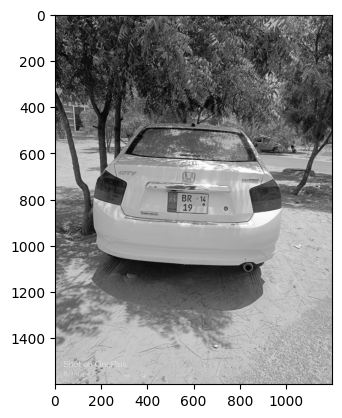

In [12]:
# image path and converted to the grayscale image
img = cv2.imread('sir.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))


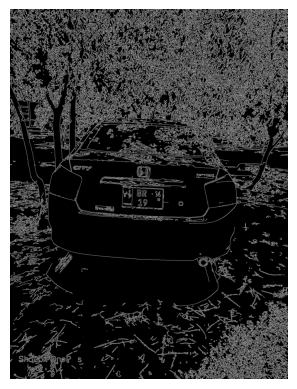

In [13]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)  # Noise reduction
edged = cv2.Canny(bfilter, 30, 200)              # Edge detection

plt.imshow(edged, cmap='gray')
plt.axis('off')
plt.show()


In [14]:

keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [15]:
# location of the number plate 
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break


In [16]:
location


array([[[529, 775]],

       [[658, 780]],

       [[656, 860]],

       [[526, 855]]], dtype=int32)

In [17]:
# First check if location exists and is valid
if location is not None and len(location) > 0:
    # Create mask
    mask = np.zeros(gray.shape, np.uint8)
    try:
        # Draw contours only if location is valid
        new_image = cv2.drawContours(mask, [location], 0, 255, -1)
        # Apply mask to original image
        new_image = cv2.bitwise_and(img, img, mask=mask)
    except cv2.error as e:
        new_image = None
        print(f"OpenCV Error: {str(e)}")
else:
    new_image = None
    print("Error: No valid number plate contour found")

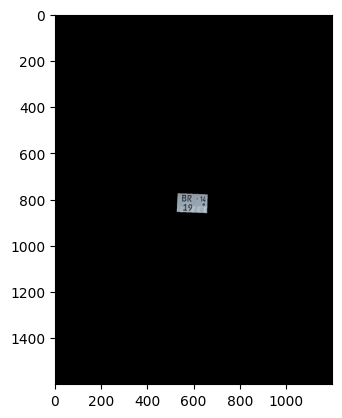

In [18]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [19]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y)) #top left corner coordinates
(x2, y2) = (np.max(x), np.max(y)) #bottom right corner coordinates
# cropping the number plate
cropped_image = gray[x1:x2+1, y1:y2+1]

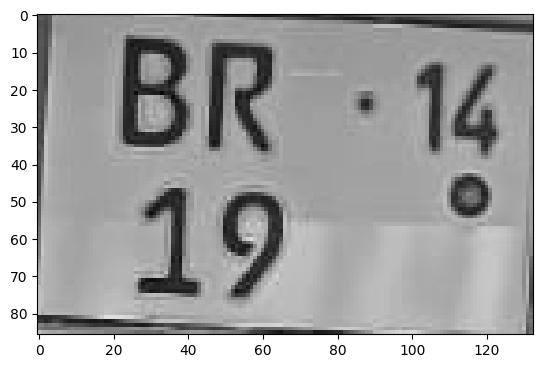

In [20]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [21]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
C:\Users\22-cu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[([[np.int32(17), np.int32(1)],
   [np.int32(71), np.int32(1)],
   [np.int32(71), np.int32(43)],
   [np.int32(17), np.int32(43)]],
  'BR',
  np.float64(0.9999476540154372)),
 ([[np.int32(96), np.int32(10)],
   [np.int32(128), np.int32(10)],
   [np.int32(128), np.int32(42)],
   [np.int32(96), np.int32(42)]],
  '14',
  np.float64(0.7926576756427286)),
 ([[np.int32(21), np.int32(41)],
   [np.int32(73), np.int32(41)],
   [np.int32(73), np.int32(83)],
   [np.int32(21), np.int32(83)]],
  '19',
  np.float64(0.9999939308592087))]

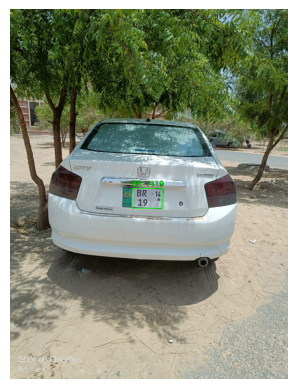

In [22]:
if len(result) > 0:
    # Get combined text
    text = ''.join([r[1] for r in result]).replace(' ', '')
    if 'BR' in text:
        text = f"BR {text.replace('BR', '')}"
    
    # Draw bounding box and text
    approx = location.reshape((4, 2))
    x, y, w, h = cv2.boundingRect(approx)
    res = img.copy()
    
    # Draw green rectangle
    cv2.rectangle(res, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Add text with outline
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(res, text, (x, y - 10), font, 1, (0, 0, 0), 3)  # outline
    cv2.putText(res, text, (x, y - 10), font, 1, (0, 255, 0), 2)  # text
    
    # Show result
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("No text was detected in the image")

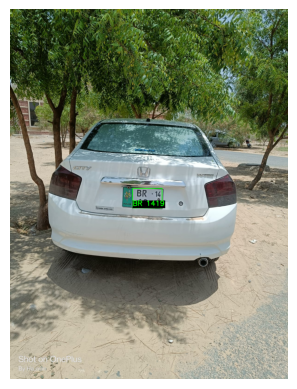

In [23]:
if len(result) > 0:
    # Extract and format text
    text = ''.join([r[-2] for r in result]).upper()
    if 'BR' in text:
        text = f"BR {''.join(c for c in text if c.isdigit())}"
    
    # Get coordinates and create image copy
    x, y = location[0][0][0], location[1][0][1]
    res = img.copy()
    
    # Draw rectangle around plate
    cv2.rectangle(res, 
                 tuple(location[0][0]), 
                 tuple(location[2][0]), 
                 (0, 255, 0), 
                 2)
    
    # Calculate text position and add background
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_size = cv2.getTextSize(text, font, 1, 2)[0]
    cv2.rectangle(res, 
                 (x, y + 70 - text_size[1]), 
                 (x + text_size[0], y + 70 + 10), 
                 (0, 0, 0), 
                 -1)
    
    # Add text
    cv2.putText(res, text, (x, y + 70), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # Show result
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("No text was detected in the image")

In [29]:
if len(result) > 0:
    text = ''.join([r[1] for r in result])
    letters = ''.join(c for c in text if c.isalpha()).upper()
    numbers = ''.join(c for c in text if c.isdigit())
    
    if letters and numbers:
        model_num = numbers[:2]  # Gets "14"
        car_num = numbers[2:]    # Gets "19"
        print(f"Car number: {letters} {car_num}")
        print(f"Model number: {model_num}")
else:
    print("No text detected")

Car number: BR 19
Model number: 14
